In [1]:
# modual imports
import numpy as np
from my_animate import animate_array, percent_print, dual_animate
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.linalg as lin
import scipy.optimize as opt

# matplotlib settings
plt.rc('axes', titlesize=20, labelsize=20)
plt.rc('axes.formatter', limits=[-4, 4])
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('lines', linewidth=1.5, markersize=7)
plt.rc('figure', figsize=[9, 9])
plt.rc('legend', fontsize=15)

## Part 1 - Advection-diffusion of a Gaussian
(The following includes several equation extracts from Matthew D Piggott's (report assessor) Numerical Methods lecture 7 and 8 notes, I will not cite these at use just know they are present, all code is original)
### Numerical Theory

Here we are solving the advection diffusion (AD) equation in one dimension:

$$\frac{\partial c}{\partial t} + U\frac{\partial c}{\partial x} = \kappa\frac{\partial^2 c}{\partial x^2}, $$

We can discretise this in space ($c \rightarrow c_i$) with a central difference scheme; using the derivatives:

$$\frac{\partial c_i}{\partial x} = \frac{c_{i+1} - c_{i-1}}{2\Delta x}$$
$$\frac{\partial^2 c_i}{\partial x^2} = \frac{c_{i+1} - 2c_i + c_{i-1}}{\Delta x^2}$$

Combining this with periodic boundary conditions, we can write the AD equation as:

$$\frac{d\boldsymbol{c}}{dt} = A \, \boldsymbol{c},$$

with:

$$
A  := \begin{pmatrix}
    \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & 0 & \ldots & \dots  & \left\{r_{\text{diff}} + r_{\text{adv}}\right\} \\
    \left\{r_{\text{diff}} + r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & 0 & & \vdots \\
    0 & \ddots & \ddots & \ddots &  & \vdots \\
    \vdots &  &  &  &  & 0 \\
      &  & 0 &\left\{r_{\text{diff}}+r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\} & \left\{r_{\text{diff}} - r_{\text{adv}}\right\}\\    
    \left\{r_{\text{diff}} - r_{\text{adv}}\right\} & \ldots & \ldots & 0 &\left\{r_{\text{diff}}+r_{\text{adv}}\right\} & \left\{-r_{\text{diff}}\right\}
\end{pmatrix}.
$$

$$r_{\text{adv}} := \frac{U}{2\Delta x}, \;\;\;\;\;\;\;\; r_{\text{diff}} := \frac{\kappa}{\Delta x^2}$$

where the top right and bottom left entries give the periodic boundaries.

Now we can discretise in time; the way in which we do this gives rise to different numerical methods. Here we will implement:

\begin{align}
\boldsymbol{c}^{n+1} &= (\Delta t \;A + I)\;\boldsymbol{c}^{n} \;\; && \text{FTCS: forward in time (FE, or RK1/AB1), central in space}\\
\boldsymbol{c}^{n+1} &= ( I - \Delta t \; A\boldsymbol )^{-1} \; \boldsymbol{c}^{n}  \;\; &&  \text{BTCS: backward in time (BE, or AM0), central in space}\\
\boldsymbol{c}^{n+1} &= \frac{U_F + U_B}{2} \; \boldsymbol{c}^{n}\;\; &&  \text{Crank-Nicolson (AM2), centeral in time and space}\\
\end{align}

where I have definied the update matrix $U_F$ and $U_B$ for forwards and backwards as the rhs brackets in FCTS and BCTS equations respectively.

## exact solution
For the initial condition of a delta function at the origin we have the exact solution of:

$$ c(x,t) = \frac{1}{\sqrt{4\pi \, \kappa \,t}}\exp\left  (-\frac{(x-Ut)^2}{4\kappa \, t}\right).$$

This will cause a zero division error at $t=0$, so we will start the system at $t=0.05$ to avoid this. There is another issue as this exact solution is over all time, hence we need to find some way to restrict it back to a periodic domain. Fortunately our equation is linear, therefore the sum of two solutions is itself a solution. We could split up every part of the analytical solution into multiple domains of length $L$ and consider each section an independent solution. If we then sum over these solutions we obtain the periodic solution.

## stability
Under stability analysis of this problem for FCTS we know the following criteria that must be met for a stable solution:

1) Looking at numerical diffusion (caused by Taylor series truncation in our numerical method) for the central scheme and requiring that physical diffusion of the system dominates of numerical diffusion we get Cell Peclet number $Pe_c =  \frac{U\Delta x}{\kappa} < 2$.

2) Looking at information propagation by advection (speed info can move through the mesh in time must be greater than the speed of information in the system) we find the CFL condition $C < C_{max}$ where $C$ is the Courant number; for Forward Euler in time this is given by $C:=\frac{U \Delta t}{\Delta x} < 1. $

3) Similarly looking at information propagation by diffusion we find the r-number condition $ r < r_{\text{max}}$ where here $ r: =  \frac{\kappa \Delta t}{\Delta x^2}$, which we can re-write using the Peclet number ($Pe = \frac{UL}{\kappa}$) as $r=\frac{C}{Pe}$.

The first condition is a property of the central difference scheme in space, the second and third however are based on the time and space evaluations together. As BCTS and Crank-Nicolson are both implicit schemes information propagates through the system differently at each time step (as we use information from the current time as well as the previous step). As such the second and third convergence criteria will not be the same for these schemes, however the actual convergence criteria I think is beyond the scope of this coursework. I will always use these conditions for FCTS and for the others caution will be taken when choosing the parameters.


### Write some code to implement the FTCS, BTCS, and Crank-Nicolson schemes

In [2]:
def cent_dis_mat(kappa, U, L, N):
    "Find the centeral difference matrix for uniform meshgrid with periodic BCs"
    # constants
    dx = L / N
    r_dif = kappa / dx**2
    r_adv = U / (2*dx)

    # find A
    first = -np.eye(N, k=1) + np.eye(N, k=-1)
    second = -2*np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1)
    A = r_adv * first + r_dif * second

    # set periodic edges
    A[0, -1] = (r_dif + r_adv)
    A[-1, 0] = (r_dif - r_adv)
    return A


def exact_solution(t, x, kappa, U):
    return np.exp(-(x-U*t)**2 / (4*kappa*t)) / np.sqrt(4*np.pi*kappa*t)


def exact_solution_periodic(t, x, kappa, U, periods=3):
    "periods is how many multiples of the range to solve over"
    # extend the x axis
    N = x.size
    r = x.max() - x.min()
    x_ext = np.concatenate([x + r*n for n in range(-periods, periods+1)])

    tmp = exact_solution(t, x_ext, kappa, U)
    return np.array([sum(tmp[i::N]) for i in range(N)])


def time_step(update_matrix, Nt, C):
    for i in range(Nt-1):
        C[i+1, :] = update_matrix @ C[i, :]
        percent_print(i, Nt)
    return C


def FTCS(Nt, Nx, t_start, x, kappa, U, L, dt):
    "solve FTCS"
    print('\nSolving FTCS with dt =', dt, ' dx = ', x[1]-x[0])

    # set up the grid and initial conditions
    C = np.empty([Nt, Nx])
    C[0, :] = exact_solution_periodic(t_start, x, kappa, U)

    # time step
    A = cent_dis_mat(kappa, U, L, Nx)
    update = dt * A + np.eye(Nx)
    return time_step(update, Nt, C)


def BTCS(Nt, Nx, t_start, x, kappa, U, L, dt):
    "solve BTCS with matrix inversion method"
    print('\nSolving BTCS with dt=', dt, ' dx = ', x[1]-x[0])

    # set up the grid and initial conditions
    C = np.empty([Nt, Nx])
    C[0, :] = exact_solution_periodic(t_start, x, kappa, U)

    # find the update
    A = cent_dis_mat(kappa, U, L, Nx)
    update = lin.inv(np.eye(Nx) - dt * A)
    
    return time_step(update, Nt, C)


def crank_nicolson(Nt, Nx, t_start, x, kappa, U, L, dt):
    "Solve Crank Nicolson with matrix inversion method"
    print('\nSolving Crank Nicolson with dt=', dt, ' dx = ', x[1]-x[0])

    # set up the grid and initial conditions
    C = np.empty([Nt, Nx])
    C[0, :] = exact_solution_periodic(t_start, x, kappa, U)

    # find the inverse matrix
    A = cent_dis_mat(kappa, U, L, Nx)
    tmp1 = lin.inv(np.eye(Nx) - dt * A / 2)
    tmp2 = (np.eye(Nx) + dt * A / 2)
    update = tmp1 @ tmp2

    return time_step(update, Nt, C)


def stability_check(dx, dt, U, L, kappa, to_print=True):
    "stability check for FCTS"
    cell_Pe = dx * U / kappa
    CFL = U * dt / dx
    r = CFL / cell_Pe
    truth = (cell_Pe < 2, CFL < 1,  0 < r < 0.5)
    if to_print is True:
        print('Pe No. = ', L * U / kappa)
        print('cell_Pe < 2', truth[0], '(%f)' % cell_Pe,
              '\nCFL < 1  ', truth[1], '(%f)' % CFL,
              '\n|r| < 0.5', truth[2], '(%f)' % r)
    return all(truth)


def de_log(x, c0, c1):
    return (x**c0) * (10**c1)

Here I have chosen to go for a matrix inversion approach to solving the implicit equations in BTCS and Crank Nicolson, as the matrix is square in the dimensions of space and only needs to be inverted once per problem and reused over every time step. Other implicit solutions would require iterations at each time step (so would be much slower) and would require caution that the non-linear solver is stable for the given problem (much more conceptually challenging). 

### Verify the correctness of your implementations
Solving this problem using a Peclet number of 200, and compare to the analytical solution known.

Pe No. =  200.0
cell_Pe < 2 True (0.400802) 
CFL < 1   True (0.099800) 
|r| < 0.5 True (0.249001)

Solving FTCS with dt = 0.0001  dx =  0.002004008016032064
Progess |##################################################|
Solving BTCS with dt= 0.0001  dx =  0.002004008016032064
Progess |##################################################|
Solving Crank Nicolson with dt= 0.0001  dx =  0.002004008016032064
Progess |##################################################|

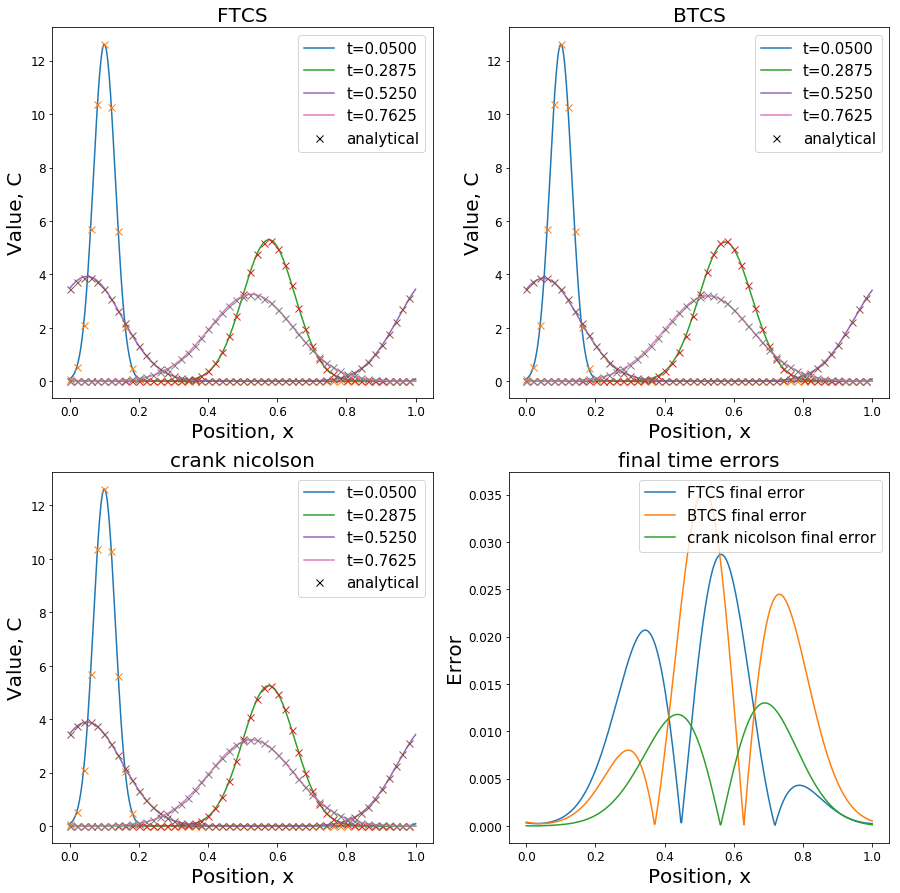

In [3]:
# parameters
kappa, L, U, N = 0.01, 1, 2, int(500)
t_start, t_end, dt = 0.05, 1, 1e-4

# constants
times = np.arange(t_start, t_end + dt, dt)
Nt = len(times)
x = np.linspace(0, L, N)
dx = (x[1]-x[0])

# stability analysis
assert stability_check(dx, dt, U, L, kappa), 'The input parameters are not stable'

# solve
t_samp = [int(i * Nt / 4) for i in range(4)]
C_FTCS = FTCS(Nt, N, t_start, x, kappa, U, L, dt)[t_samp]
C_BTCS = BTCS(Nt, N, t_start, x, kappa, U, L, dt)[t_samp]
C_cran = crank_nicolson(Nt, N, t_start, x, kappa, U, L, dt)[t_samp]
exact = [exact_solution_periodic(t, x, kappa, U) for t in times[t_samp]]

# plot
fig, axs = plt.subplots(2, 2, figsize=[15,15])
axs = axs.flatten()
names = ['FTCS', 'BTCS', 'crank nicolson']
for i_ax, method in enumerate([C_FTCS, C_BTCS, C_cran]):
    for i_sol, sol in enumerate(method):
        axs[i_ax].plot(x, sol, '-', label='t=%.4f' % times[t_samp][i_sol])  # numerical
        axs[i_ax].plot(x[::10], exact[i_sol][::10], 'x')  # analytical
    axs[3].plot(x, abs(sol-exact[i_sol]), label='%s final error' % names[i_ax])  # error

# add titles etc
for i, ax in enumerate(axs[:3]):
    ax.plot([], [], 'kx', label='analytical')  # to generate label once
    ax.legend()
    ax.set(xlabel='Position, x', ylabel='Value, C', title=names[i])
axs[3].set(xlabel='Position, x', ylabel='Error', title='final time errors')
axs[3].legend()

The solutions here look rather good, the periodic boundaries seem to be working as the solution loops over the domain at least once for both the numerical and analytical solutions. We can see from the bottom right plot that the errors are $\sim 10^{-2}$ which is seems reasonable given $dt=10^{-4}$ and $dx=2 \times 10^{-3}$ is being solved for over one period.
The interesting behavior comes from comparing the errors, unsurprisingly Crank Nicolson is best as it is trapezodial in time, however we see forwards in time is better than backwards. Exactly why this is the case is would require further investigation, though possible explanations are:

- the inversion that occurs for BCTS introduces some significant numerical error, though inversion methods are technically exact the use of many calculations built on top of each-other could allow floating round off errors to accumulate in the final inverted matrix
- the asymmetry of advection being in one direction could favour a particular direction in time
- the tendency for each to consistently over or underestimate in certain situations may be better or worse for this particular problem

### What theoretical orders of accuracy do you expect for your three solvers
From the accuracy orders of the individual methods which comprise each of our methods. We know that:

- Forwards/Backwards Euler are first order schemes for the first derivatives
- Trapezodial (a.k.a central difference) is a second order scheme for the first derivatives
- For the second derivative with central difference we expect first order error as we are taking the difference of the first derivatives:

<img src="./figs/cd_scheme.jpg" width=200px>

Hence we expect the following orders:
- FTCS $= \mathcal{O}(dt^1) + \mathcal{O}(dx^1)$ as Forward Euler in time and central difference in space for a second derivative
- BTCS $= \mathcal{O}(dt^1) + \mathcal{O}(dx^1)$ as Backward Euler in time and central difference in space for a second derivative
- Crank Nicolson $= \mathcal{O}(dt^2) + \mathcal{O}(dx^1)$ as central difference (Trapezodial) in time and central difference in space for a second derivative

###  Confirm these orders of accuracy through convergence analyses

The dual dependence of errors above means we need caution when it comes to convergence analysis as the largest error will dominate, so we need to pick the physical parameters such that we think either dt or dx will dominate over the range of step sizes we are using.

For FCTS it makes sense to find the dx, dt range we are allowed to work with given our stability criteria. 

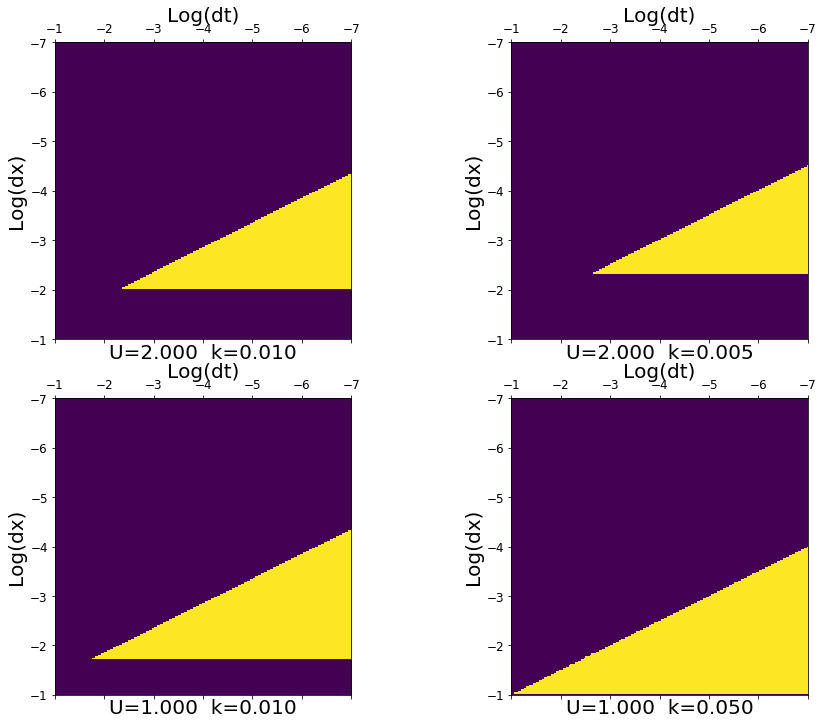

In [4]:
def dx_dt_range(U, k, n=200):
    
    # generate dx, dts that we could reasonably run
    dx_range = np.geomspace(0.1, 1e-7, n)
    dt_range = np.geomspace(0.1, 1e-7, n)
    truth = np.zeros([n, n])
    
    # for each of these check wether they are stable
    for i in range(n):
        for j in range(n):
            dx, dt = dx_range[i], dt_range[j]
            if stability_check(dx, dt, U, 1, k, to_print=False):
                truth[i, j] = 1

    return dx_range, dt_range, truth

# setup
Us = [2, 2, 1, 1]
Ks = [0.01, 0.005, 0.01, 0.05]
fig, axs = plt.subplots(2, 2, figsize=[15, 12])
axs = axs.flatten()

# solve and plot
for i, ax in enumerate(axs):
    x, t, c = dx_dt_range(Us[i], Ks[i])
    x, t = np.log10(x), np.log10(t)  # log so the imshows axis make sense
    ax.set(xlabel='U=%.3f  k=%.3f' % (Us[i], Ks[i]), title='Log(dt)', ylabel='Log(dx)')
    im = ax.matshow(c, extent=[t[0], t[-1], x[0], x[-1]], origin=1)

In the above parameter space yellow means viable for FCTS. We want dx to be as small as reasonably possible so that dt dominates the error, whilst still giving us a range of dt to show convergence over. This is more easily possible for FCTS and BCTS as they are expected to be less accurate in time than in space however this will be an issue for Crank Nicolson as dt and dx are expected to have the same error orders.

From above it seems that a choice of $u=2$, $k=0.01$ at a dx of $\sim 10^{-2 \; or \; 3}$ gives a good range of viable dt of around 4 orders of magnitude before being to small to reasonably solve for, so this will be my range choice for the first attempt.

In [5]:
def convergence_time(Nts, Nx, t_start, x, kappa, U, L, dts, method, t_end):
    "vary time for covergence plot"
    
    # setup
    errors = []
    final_val = exact_solution_periodic(t_end, x, kappa, U, periods=10)
    
    # solve for each dt
    for dt, Nt in zip(dts, Nts):
        sol = method(Nt, Nx, t_start, x, kappa, U, L, dt)
        diff_sq = (sol[-1, :] - final_val)**2
        rms = np.sqrt(diff_sq.sum()/Nx)
        errors.append(rms)
    return errors


# parameters
kappa, L, U, N = 0.01, 1, 2., int(200)
t_start, t_end = 0.1, 2.
dts = np.array([1e-3 / 1.25**n for n in range(15)])

# constants
time_list = [np.arange(t_start, t_end + dt, dt) for dt in dts]
Nts = [len(time) for time in time_list]
x = np.linspace(0, L, N)
dx = (x[1]-x[0])

# stability analysis
for dt in dts:
    print('\nstability for dt = ', dt)
    assert stability_check(dx, dt, U, L, kappa, to_print=True), 'The input parameters are not stable'

# solve
errors_FTCS = convergence_time(Nts, N, t_start, x, kappa, U, L, dts, FTCS, t_end)
errors_BTCS = convergence_time(Nts, N, t_start, x, kappa, U, L, dts, BTCS, t_end)
errors_crank = convergence_time(Nts, N, t_start, x, kappa, U, L, dts, crank_nicolson, t_end)
print('\ndone')


stability for dt =  0.001
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.398000) 
|r| < 0.5 True (0.396010)

stability for dt =  0.0008
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.318400) 
|r| < 0.5 True (0.316808)

stability for dt =  0.00064
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.254720) 
|r| < 0.5 True (0.253446)

stability for dt =  0.000512
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.203776) 
|r| < 0.5 True (0.202757)

stability for dt =  0.0004096
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.163021) 
|r| < 0.5 True (0.162206)

stability for dt =  0.00032768
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.130417) 
|r| < 0.5 True (0.129765)

stability for dt =  0.000262144
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.104333) 
|r| < 0.5 True (0.103812)

stability for dt =  0.0002097152
Pe No. =  200.0
cell_Pe < 2 True (1.005025) 
CFL < 1   True (0.083467)

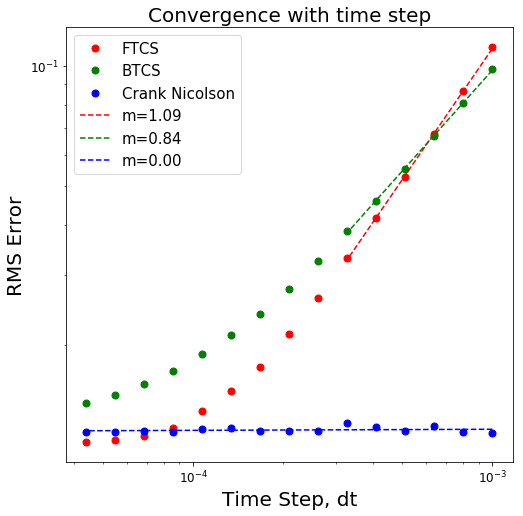

In [6]:
# plot results
fig, ax = plt.subplots(figsize=[8, 8])
names = ['FTCS', 'BTCS', 'Crank Nicolson']
colors = ['r', 'g', 'b']
for i, err in enumerate([errors_FTCS, errors_BTCS, errors_crank]):
    ax.loglog(dts, err, colors[i]+'o', label=names[i])

# fit to linear regions to FTCS and BCTS
log_dts = np.log10(dts)
FCTS_params = np.polyfit(log_dts[:6], np.log10(errors_FTCS)[:6], 1)
BCTS_params = np.polyfit(log_dts[:6], np.log10(errors_BTCS)[:6], 1)
crank_params = np.polyfit(log_dts, np.log10(errors_crank), 1)

# plot linear fits
ax.plot(dts[:6], de_log(dts[:6], *FCTS_params), colors[0]+'--', label='m=%.2f' % FCTS_params[0])
ax.plot(dts[:6], de_log(dts[:6], *BCTS_params), colors[1]+'--', label='m=%.2f' % BCTS_params[0])
ax.plot(dts, de_log(dts, *crank_params), colors[2]+'--', label='m=%.2f' % crank_params[0])

# add titles, annotations etc
ax.set(xlabel='Time Step, dt', ylabel='RMS Error', title='Convergence with time step')
ax.legend()

Here the linear log space fits for FCTS and BCTS are only using the first 6 points where the results appear linear. After these dx begins to become significant until the graph fully levels off once dt is the no longer significant to the overall error. This was the case for Crank Nicolson all along, which makes sense as $dx > dt^2$ for this entire region. 

We can't actually meet the criteria that $dx < dt^2$ for the given stability regions. Upon several trial and errors without the stability analysis I have come to realise that making dt dominant is not actually possible as due to the matrix inversion being of dimensions $\mathcal{O}(N^2) \times \mathcal{O}(N^2)$ there is a very large scaling of run time with decreasing dx (depending on how scipy works it likely scales with $\mathcal{O}(N^2)$ or $\mathcal{O}(NlogN)$). This is all not to mention the possibility of the numerical constants for these error orders being large enough to offset the initial error significantly. As such getting dx small enough to show time convergence is not easily possible here.

Looking at the gradients we confirm that FCTS is better than BCTS for this specific problem and again the reasons for this are not certain, though my current feeling would be that the matrix inversion cause previously discussed is most likely here. Both are approximately $1^{st}$ order accuracy so agree with the theory to a reasonable extent, though preferably a larger linear region should be used to find these more accurately (not done here due to time restraints). The fact that each method levels off to roughly the same order of magnitude suggests that they are all of the same order of error in space. I will test this now by considering space convergence. Again I will have to be cautious about the parameter choice in order to have stability and see convergence. Since we want a large range of dx it makes sense to choose $k=0.05$, $U=1$ from the previous stability analysis.

In [7]:
def convergence_space(Nt, Nxs, t_start, xs, kappa, U, L, dt, method, t_end):
    "vary space for covergence plot"
    # setup
    errors = []
    
    # solve for each dx
    for x, Nx in zip(xs, Nxs):
        final_val = exact_solution_periodic(t_end, x, kappa, U, periods=10)
        sol = method(Nt, Nx, t_start, x, kappa, U, L, dt)
        diff_sq = (sol[-1, :] - final_val)**2
        rms = np.sqrt(diff_sq.sum()/Nx)
        errors.append(rms)
    return errors

# parameter
kappa, L, U = 0.05, 1, 2
t_start, t_end, dt = 0.1, 1., 5e-5
Ns = np.array([1 + 20*n for n in range(2, 20)])

# constants
times = np.arange(t_start, t_end + dt, dt)
Nt = len(times)
xs = [np.linspace(0, L, N) for N in Ns]
dxs = [x[1]-x[0] for x in xs]

# stability analysis
for dx in dxs:
    print('\nstability for dx = ', dx)
    assert stability_check(dx, dt, U, L, kappa, to_print=False), 'The input parameters are not stable'

# solve
errors_FTCS = convergence_space(Nt, Ns, t_start, xs, kappa, U, L, dt, FTCS, t_end)
errors_BTCS = convergence_space(Nt, Ns, t_start, xs, kappa, U, L, dt, BTCS, t_end)
errors_crank = convergence_space(Nt, Ns, t_start, xs, kappa, U, L, dt, crank_nicolson, t_end)
print('\ndone')


stability for dx =  0.025

stability for dx =  0.016666666666666666

stability for dx =  0.0125

stability for dx =  0.01

stability for dx =  0.008333333333333333

stability for dx =  0.007142857142857143

stability for dx =  0.00625

stability for dx =  0.005555555555555556

stability for dx =  0.005

stability for dx =  0.004545454545454545

stability for dx =  0.004166666666666667

stability for dx =  0.0038461538461538464

stability for dx =  0.0035714285714285713

stability for dx =  0.0033333333333333335

stability for dx =  0.003125

stability for dx =  0.0029411764705882353

stability for dx =  0.002777777777777778

stability for dx =  0.002631578947368421

Solving FTCS with dt = 5e-05  dx =  0.025
Progess |##################################################|
Solving FTCS with dt = 5e-05  dx =  0.016666666666666666
Progess |##################################################|
Solving FTCS with dt = 5e-05  dx =  0.0125
Progess |##################################################|

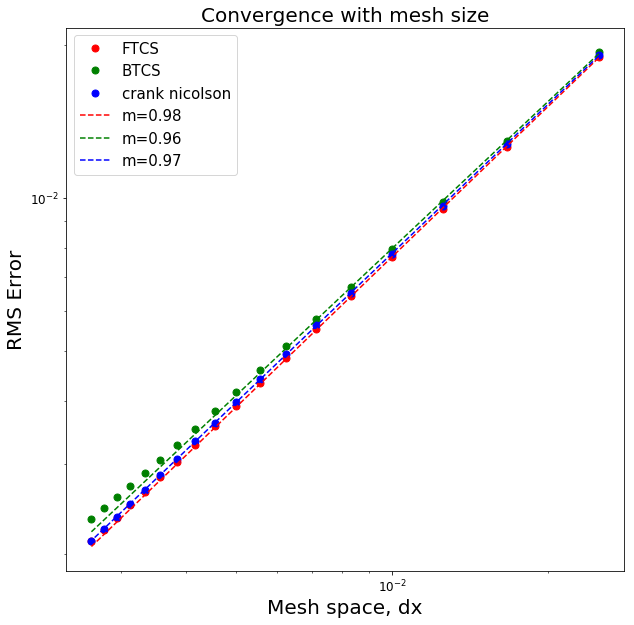

In [8]:
# plot
fig, ax = plt.subplots(figsize=[10, 10])
names = ['FTCS', 'BTCS', 'crank nicolson']
colors = ['r', 'g', 'b']
for i, err in enumerate([errors_FTCS, errors_BTCS, errors_crank]):
    ax.loglog(dxs, err, colors[i]+'o', label=names[i])

# fit to linear regions to FTCS and BCTS
log_dxs = np.log10(dxs)
FCTS_params = np.polyfit(log_dxs[:6], np.log10(errors_FTCS)[:6], 1)
BCTS_params = np.polyfit(log_dxs[:6], np.log10(errors_BTCS)[:6], 1)
crank_params = np.polyfit(log_dxs, np.log10(errors_crank), 1)

# plot linear fits
ax.plot(dxs, de_log(dxs, *FCTS_params), colors[0]+'--', label='m=%.2f' % FCTS_params[0])
ax.plot(dxs, de_log(dxs, *BCTS_params), colors[1]+'--', label='m=%.2f' % BCTS_params[0])
ax.plot(dxs, de_log(dxs, *crank_params), colors[2]+'--', label='m=%.2f' % crank_params[0])

# add titles etc
ax.set(xlabel='Mesh space, dx', ylabel='RMS Error', title='Convergence with mesh size')
ax.legend()

Since here space is dominant throughout and each method uses the same spacial finite difference method the solutions are almost in-separable. Each has a gradient just under 1st order, which is what we would expect as other higher order error terms in dt or dx bring the methods below the best they can be. 

Since we now know for sure that they all have the same space error order we can conclude from the previous plot that Crank Nicolson is better than first order error in time, though could possibly be better that 2nd order.

## Part 2 - Variable mesh resolution

### Theory
Now we are solving for the same equation as before but with Dirichlet boundaries and looking for the steady state solution. This simplifies our original equation to the LHS being zero, giving us a single equation to solve. Just as before we can solve this problem by a matrix inversion, however now we have the additional factor of ghost nodes to consider in order to have the second derivative at the first node. I am free to choose how these are implemented, I see two choices:

<img src="./figs/node_diagram.jpg" width=900px>

Hollow circles are ghost nodes and solid are the real nodes we are solving for.

1) Boundary between the ghost node and the first node. This then means that we have to change $C^t_{-1}$ so that $\theta_L = \frac{\alpha C^t_{-1} + \beta C^t_{0}}{2}$ is always true. The advantage of this setup is that it is fairly strait forward to impose Newman boundaries (i.e. fixed first derivative at the boundary). There is an additional complication for non-uniform meshes as we have one condition ($\theta_L$) and two free parameters ($\alpha \; \& \;  C^t_{-1}$) so we have to choose one.

2) Ghost node on the boundary. This is advantageous as $C^t_{-1}$ remains unchanged throughout, allowing the equations to be simpler. However, as the first derivative at a node is poorly defined for finite difference methods (it is better defined on a range between two nodes, such as that shown in 1).

Since here we only have Dirichlet boundaries I will implement the second method as this requires less complication when it comes to non-uniform mesh grids later (no chance of accidentally putting a node outside the boundaries).


For the case of boundary conditions $[0, 1]$ at boundaries $[0, 1]$ respectively we have the analytical solution:
$$ c(x) = \frac{\exp\left(Pe \; x\right) - 1}{\exp(Pe) - 1}.$$


### Write a solver that uses a non-uniform mesh

<img src="./figs/non_uniform_maths.jpg" width=900px>

Using these constants I can form the discretisation matrix to create a solver for a general non-uniform matrix. I will set up the function to expect the limits in the $x$ input.

In [9]:
def ghost_nuni_dis_mat(x, kappa, U):
    "lims are the edge nodes"

    # find dx array
    dx = np.diff(x)
    N = len(x)-2

    # set up matrix
    A = np.zeros([N+2, N+2])
    tmp1 = -2 * kappa
    tmp2 = U / 2
    
    # find matrix entries
    for i in range(1, N+1):
        sigma = (dx[i] + dx[i-1]) * dx[i] * dx[i-1]
        A[i, i-1] = -dx[i] * tmp1 / sigma - tmp2 * (-1/dx[i-1])
        A[i, i] = (dx[i] + dx[i-1]) * tmp1 / sigma - tmp2 * ((1/dx[i-1]) - (1/dx[i]))
        A[i, i+1] = -dx[i-1] * tmp1 / sigma - tmp2 * (1/dx[i])

    # add in the ghost nodes
    A[0, 0] = 1.
    A[-1, -1] = 1.

    return A


def ghost_uni_dis(Nx, lims, kappa, U):
    "Find the centeral difference matrix for uniform meshgrid"
    
    # find x array
    x = np.linspace(lims[0], lims[1], Nx)
    dx = x[1] - x[0]

    # set up matrix
    A = np.zeros([Nx, Nx])
    tmp1 = -2 * dx * kappa
    tmp2 = U / 2
    
    # find matrix entries
    for i in range(1, Nx-1):
        sigma = 2 * dx**3
        A[i, i-1] = -tmp1 / sigma - tmp2 * (-1/dx)
        A[i, i] = 2 * tmp1 / sigma - tmp2 * ((1/dx) - (1/dx))
        A[i, i+1] = -tmp1 / sigma - tmp2 * (1/dx)

    # add in the ghost nodes
    A[0, 0] = 1.
    A[-1, -1] = 1.

    return A


def stationary_exact(Pe, x):
    return (np.exp(x*Pe) - 1) / (np.exp(Pe) - 1)


def stationary_uniform(Nx, kappa, U, L, BVals, lims):
    "solve for stantionary solution with uniform spacal grid using numpy linalg solve"
    print('Solving steady state with uniform dx = ', 1/(Nx-1))
    # set up the RHS with boundary conditions
    RHS = np.zeros(Nx)
    RHS[0] = BVals[0]
    RHS[-1] = BVals[1]
    
    # find the matrix and add periodicity
    A = ghost_uni_dis(Nx, lims, kappa, U)

    return np.linalg.solve(A, RHS)


def stationary_nonuniform(x, kappa, U, L, BVals, lims):
    """Solve the steady state of advection diffusion using numpy linalg solve,
    x contains the ghost nodes i.e. lim x values"""
    print('Solving steady state with non-uniform dx = ', np.diff(x).mean())

    # set up the RHS with boundary conditions
    RHS = np.zeros(len(x))
    RHS[0] = BVals[0]
    RHS[-1] = BVals[1]

    # find the matrix
    A = ghost_nuni_dis_mat(x, kappa, U)
    return np.linalg.solve(A, RHS)


def non_uni_dist(L, N):
    """
    returns n nterior points distributed on [0, L] such that the distance between
    consecutive values linearly decreases from 0, L
    """
    icdf = lambda x, m:np.sqrt(2*x/m)
    m = 2 / L**2
    x = np.linspace(0, L, N+2)
    return icdf(x, m)

## Verify against the original uniform mesh version

To verify the non-uniform solver we need a choice of non-uniform mesh to compare with the uniform mesh solver. I can use the knowledge of the exact solution to guess a good choice for non-uniform mesh, ideally it should be consistent enough that asking for additional points does not change the overall shape of the mesh (i.e. the relative interval density should be the same regardless of the number of points). Hence I will use a pdf that linearly increases over the range of x and define an inverted cumulative density function to convert a uniform distribution over $[0,1]$ to a consistent non-uniform distribution over the same range. The function that does this is seen above and is shown to give a reasonable mesh below.

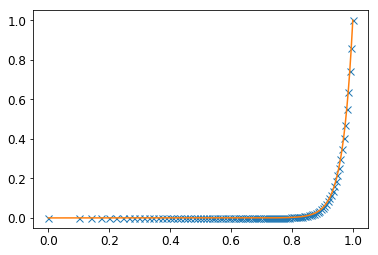

In [11]:
# setup
kappa, U, L = 0.1, 3., 1.
BV = [0., 1.]
lims = [0., 1.]
Pe = U * L / kappa

# generate mesh
x = non_uni_dist(1, 100)
y = stationary_exact(Pe, x)

# plot
x_tmp = np.linspace(0, 1, 10000)
plt.plot(x, y, 'x', label='generated mesh')
plt.plot(x_tmp, stationary_exact(Pe, x_tmp), '-', label='analytical')

Solving steady state with non-uniform dx =  0.009708737864077669
Solving steady state with uniform dx =  0.009900990099009901
Solving steady state with non-uniform dx =  0.009900990099009901


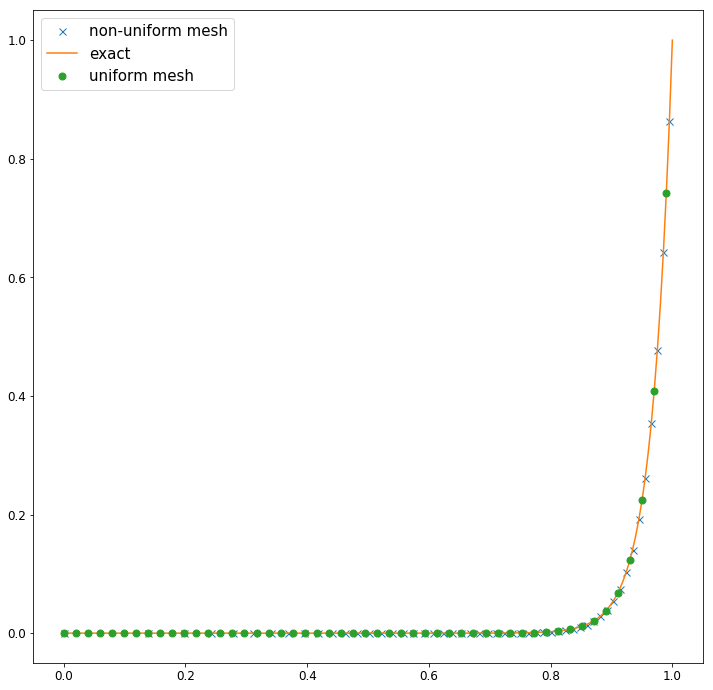

In [12]:
# setup
kappa, U, L = 0.1, 3., 1.
BV = [0., 1.]
lims = [0., 1.]
Pe = U * L / kappa

# grids
N = 102
x_nuni = non_uni_dist(L, N)
x_uni = np.linspace(0., L, N)

# solve
C_nuni = stationary_nonuniform(x_nuni, kappa, U, L, BV, lims)
C_uni = stationary_uniform(N, kappa, U, L, BV, lims)
C_exact = stationary_exact(Pe, x_nuni)
C_test = stationary_nonuniform(x_uni, kappa, U, L, BV, lims)

# plot
fig, ax = plt.subplots(figsize=[12, 12])
ax.plot(x_nuni[::2], C_nuni[::2], 'x', label='non-uniform mesh')
ax.plot(x_nuni, C_exact, '-', label='exact')
ax.plot(x_uni[::2], C_test[::2], 'o', label='uniform mesh')
ax.plot()
ax.legend()

Seems like the non-uniform method is doing well.

## Verify against the analytical solution
Now we can do convergence of the above example using a mesh of increasing number of points (i.e. decreasing average dx). I will also run a uniform mesh through the non-uniform method to check that it reduces to the same form.

Solving steady state with non-uniform dx =  0.02
Solving steady state with non-uniform dx =  0.015151515151515152
Solving steady state with non-uniform dx =  0.011494252873563218
Solving steady state with non-uniform dx =  0.008771929824561403
Solving steady state with non-uniform dx =  0.006711409395973154
Solving steady state with non-uniform dx =  0.00510204081632653
Solving steady state with non-uniform dx =  0.0038910505836575876
Solving steady state with non-uniform dx =  0.002967359050445104
Solving steady state with non-uniform dx =  0.0022624434389140274
Solving steady state with non-uniform dx =  0.0017211703958691911
Solving steady state with non-uniform dx =  0.0013123359580052493
Solving steady state with non-uniform dx =  0.000999000999000999
Solving steady state with non-uniform dx =  0.020833333333333332
Solving steady state with uniform dx =  0.020833333333333332
Solving steady state with non-uniform dx =  0.015625
Solving steady state with uniform dx =  0.015625
Solvi

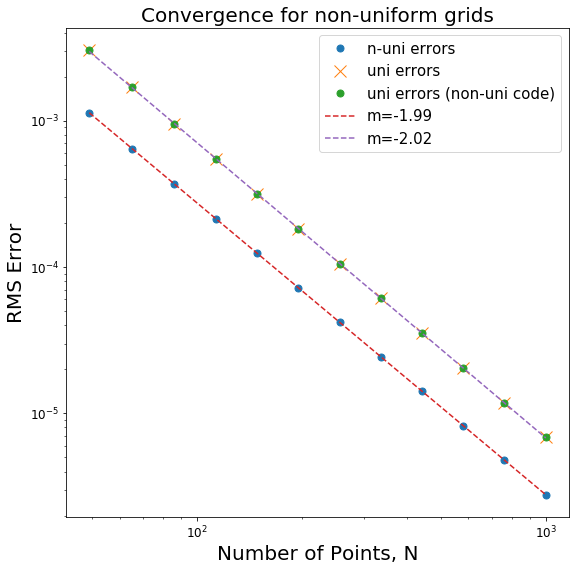

In [13]:
# params
kappa, U, L = 1/30, 1., 1.
BV = [0., 1.]
lims = [0., 1.]
Pe = U * L / kappa

# different grids
# Ns = [20 * int(1.5**n) for n in range(2, 14)]
Ns = np.geomspace(50, 1000, 12).astype(int)
xs_nuni = [non_uni_dist(L, N) for N in Ns]
xs_uni = [np.linspace(0., 1., N) for N in Ns]

# find error for non-uniform method
errors_nuni = []
for N,x in zip(Ns, xs_nuni):
    C_num = stationary_nonuniform(x, kappa, U, L, BV, lims)
    C_exact = stationary_exact(Pe, x)
    diff_sq = (C_num-C_exact)**2
    errors_nuni.append(np.sqrt(diff_sq.sum()/N))

# find error for uniform grid with non-uniform method
errors_uni_test = []
errors_uni = []
for N,x in zip(Ns, xs_uni):
    C_num = stationary_nonuniform(x, kappa, U, L, BV, lims)
    C_exact = stationary_exact(Pe, x)
    diff_sq = (C_num-C_exact)**2
    errors_uni_test.append(np.sqrt(diff_sq.sum()/N))    
    
    C_num = stationary_uniform(N, kappa, U, L, BV, lims)
    C_exact = stationary_exact(Pe, x)
    diff_sq = (C_num-C_exact)**2
    errors_uni.append(np.sqrt(diff_sq.sum()/N))  

# plot solutions
fig, ax = plt.subplots(figsize=[9, 9])
ax.loglog(Ns, errors_nuni, 'o', ms=7, label='n-uni errors')
ax.loglog(Ns, errors_uni, 'x', ms=12, lw=3, label='uni errors')
ax.loglog(Ns, errors_uni_test, 'o', ms=7, label='uni errors (non-uni code)')
ax.set(xlabel='Number of Points, N', ylabel='RMS Error', title='Convergence for non-uniform grids')
    
# fit to linear regions to FTCS and BCTS
log_Ns = np.log10(Ns)
uni_params = np.polyfit(log_Ns[:], np.log10(errors_nuni), 1)
nuni_params = np.polyfit(log_Ns[:], np.log10(errors_uni), 1)

# plot linear fits
ax.plot(Ns, de_log(Ns, *uni_params), '--', label='m=%.2f' % uni_params[0])
ax.plot(Ns, de_log(Ns, *nuni_params), '--', label='m=%.2f' % nuni_params[0])
ax.legend()

Note here gradients are negative as we have N on the x axis which is the inverse of average dx.

Firstly, we see that the non-uniform solver with the uniform mesh agrees with the uniform solver, so we know the non-uniform equations are consistent with the uniform ones.

Secondly, both methods are $2^{nd}$ order convergent, though the spacial methods are the same as part one where we found them to be $1^{st}$ order. However here we are only solving for a single "step", where as before we were solving over multiple times. In other words here we are looking at the local error, not the global error, so one order better makes sense.

Thirdly, the non-uniform mesh is consistently better than the uniform mesh. This is good as otherwise this section would be pointless.

## Extension: Solve with time 

So the update matrix previously made for solving in time can be found from the above discretisation matrix easily. This allows us to solve over time to see how the situation advances and convince ourselves of the given solution. As an extension (and because it is fun) I implemented this in the file "time_solve.py". I did not put it here but if you want to have a look just run the file (it looks quite pretty).

## generate a non-uniform mesh with solution arclength approximately equal between mesh points
To do this a high resolution sample of the exact solution is used, then taking the cumulative sum to find the x points at which the arc length is roughly constant.

average arc diff = 0.010570840024390585 
standard deviation =  0.025215852285620396


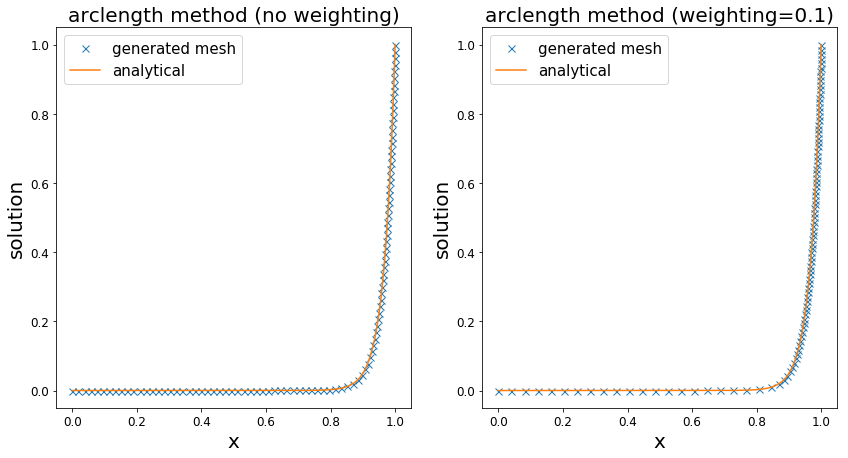

In [14]:
def generate_mesh(N, samp, L, kappa, U, weight=1):
    "samp can be large as this is cheap"

    # sample the exact solution and calculate the line segment lengths
    x_samp = np.linspace(0, L, samp)
    y_samp = stationary_exact(Pe, x_samp)
    dxs = np.diff(x_samp)
    dys = np.diff(y_samp)
    arc_lengths = [np.sqrt(weight*dx**2 + dy**2) for dx, dy in zip(dxs, dys)]
    cum_lengths = np.cumsum(arc_lengths)
    
    # generate non-uniform mesh
    x_choice = np.empty(N)    
    tmp = np.linspace(0, cum_lengths[-1], N)
    for i, val in enumerate(tmp):
        index = np.where(val <= cum_lengths)[0][0]
        x_choice[i] = x_samp[index]
    x_choice[-1] = L  # the final point is always just below L
    return x_choice

# params
kappa, U, L = 1/30, 1., 1.
BV = [0., 1.]
lims = [0., 1.]
Pe = U * L / kappa

# generate mesh
x1 = generate_mesh(100, 10000, L, kappa, U)
y1 = stationary_exact(Pe, x1)
x2 = generate_mesh(100, 10000, L, kappa, U, weight=0.1)
y2 = stationary_exact(Pe, x2)

# plot
fig, ax = plt.subplots(1, 2, figsize=[14, 7])
x_ext = np.linspace(0, 1, 10000)
y_ext = stationary_exact(Pe, x_tmp)

ax[0].plot(x1, y1, 'x', label='generated mesh')
ax[0].plot(x_tmp, y_ext, '-', label='analytical')
ax[0].legend()
ax[0].set(xlabel='x', ylabel='solution', title='arclength method (no weighting)')

ax[1].plot(x2, y2, 'x', label='generated mesh')
ax[1].plot(x_tmp, y_ext, '-', label='analytical')
ax[1].legend()
ax[1].set(xlabel='x', ylabel='solution', title='arclength method (weighting=0.1)')

# check arclength consistency
dxs = np.diff(x)
dys = np.diff(y)
arc_lengths = [np.sqrt(dx**2 + dy**2) for dx, dy in zip(dxs, dys)]
print('average arc diff =', np.mean(arc_lengths), '\nstandard deviation = ', np.std(arc_lengths))

The standard deviation above is for the left hand plot and is around two orders of magnitude less than the average difference between consecutive points, which shows that the arc lengths are pretty consistent. Looking at this the graph it does not seem to sample the range particularly well as the arc length in the flat regions is still similar to the steep regions. One possible improvement would be to use the weight factor to prioritise the dy values, shown on the right for weight=0.1 and it seems quite good as there is a higher density of points near where the solution is more significant (on the far right).

From the lectures we were given an equation for the optimal stretched mesh for this process:

$$ x = L \frac{\sinh^{-1}(\sinh(a)\xi)}{a}, $$

where a is a variabile parameter, which for $Pe\approx30$ is optimal at around $a=10$. I will generate a mesh the given problem to see what it looks like. 

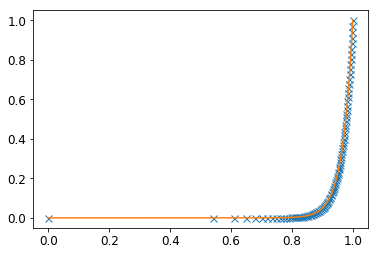

In [15]:
def stretch_func(xi, a=10):
    "from lecture 7"
    x = L * np.arcsinh(np.sinh(a)*xi)/a
    return x

# params
kappa, U, L = 1/30, 1., 1.
BV = [0., 1.]
lims = [0., L]
Pe = U * L / kappa

# generate mesh and check arclength aconsistency
x = stretch_func(np.linspace(0, 1, 100))
y = stationary_exact(Pe, x)

# plot
x_tmp = np.linspace(0, 1, 10000)
plt.plot(x, y, 'x', label='generated mesh')
plt.plot(x_tmp, stationary_exact(Pe, x_tmp), '-', label='analytical')

seems more like the pdf method initially used than either of the numerically generated meshes. But the proof is in the pudding, lets run a convergence analysis for all of the above methods.

generating grids...
done
Solving steady state with non-uniform dx =  0.020833333333333332
Solving steady state with non-uniform dx =  0.015625
Solving steady state with non-uniform dx =  0.011764705882352941
Solving steady state with non-uniform dx =  0.008928571428571428
Solving steady state with non-uniform dx =  0.006802721088435374
Solving steady state with non-uniform dx =  0.005154639175257732
Solving steady state with non-uniform dx =  0.00392156862745098
Solving steady state with non-uniform dx =  0.0029850746268656717
Solving steady state with non-uniform dx =  0.0022727272727272726
Solving steady state with non-uniform dx =  0.0017271157167530224
Solving steady state with non-uniform dx =  0.0013157894736842105
Solving steady state with non-uniform dx =  0.001001001001001001
Solving steady state with non-uniform dx =  0.020833333333333332
Solving steady state with non-uniform dx =  0.015625
Solving steady state with non-uniform dx =  0.011764705882352941
Solving steady state 

[Text(0,0.5,'RMS Error'),
 Text(0.5,0,'Number of points, N'),
 Text(0.5,1,'Convergence for vairous mesh grid choices')]

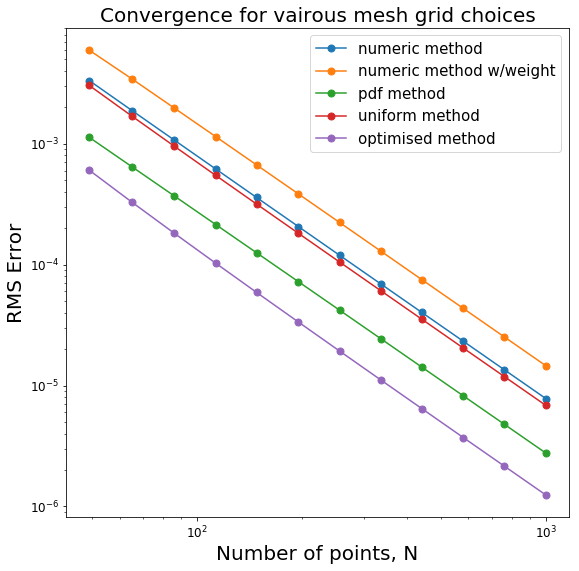

In [16]:
# params
kappa, U, L = 1/30, 1., 1.
BV = [0., 1.]
lims = [0., 1.]
Pe = U * L / kappa

# different grids
print('generating grids...')
Ns = np.geomspace(50, 1000, 12).astype(int)
xs_nuni_1 = [generate_mesh(N, N*100, L, kappa, U) for N in Ns]  # numeric method
xs_nuni_2 = [generate_mesh(N, N*100, L, kappa, U, weight=0.1) for N in Ns]  # numeric method with weighting
xs_nuni_3 = [non_uni_dist(L, N) for N in Ns]  # pdf method
xs_uni = [np.linspace(0., 1., N) for N in Ns]  # uniform method
xs_opt = [stretch_func(x) for x in xs_uni]  # optimised method
print('done')

# find error for non-uniform method
errors = []
for xs in [xs_nuni_1, xs_nuni_2, xs_nuni_3, xs_uni, xs_opt]:
    errors_tmp = []
    for N, x in zip(Ns, xs):
        C_num = stationary_nonuniform(x, kappa, U, L, BV, lims)
        C_exact = stationary_exact(Pe, x)
        diff_sq = (C_num - C_exact)**2
        errors_tmp.append(np.sqrt(diff_sq.sum() / N))
    errors.append(errors_tmp)

# plot
fig, ax = plt.subplots(figsize=[9, 9])
labels = ['numeric method', 'numeric method w/weight', 'pdf method', 'uniform method', 'optimised method']

for err, lab in zip(errors, labels):
    ax.loglog(Ns, err, '-o', label=lab)
ax.legend()
ax.set(title='Convergence for vairous mesh grid choices', xlabel='Number of points, N', ylabel='RMS Error')

The consistency of the gradients suggest that these convergence plots are correct. However the interesting behaviour is that the numerical sampling methods appear to be worse than the uniform method, and even the "better looking" weighted version is worse still. However we know the non-uniform solver is working from the pdf and optimised solutions, and we know the non-uniform mesh generators are behaving as expected from their arc length standard deviations. There must be some factor in the differences between the mesh techniques that cause this behaviours.

After much consideration I belive the best way to demonstrate why I think this happens is to look at how the dx changes over the domain. 

[Text(0,0.5,'dx'), Text(0.5,0,'x/L'), Text(0.5,1,'dx density')]

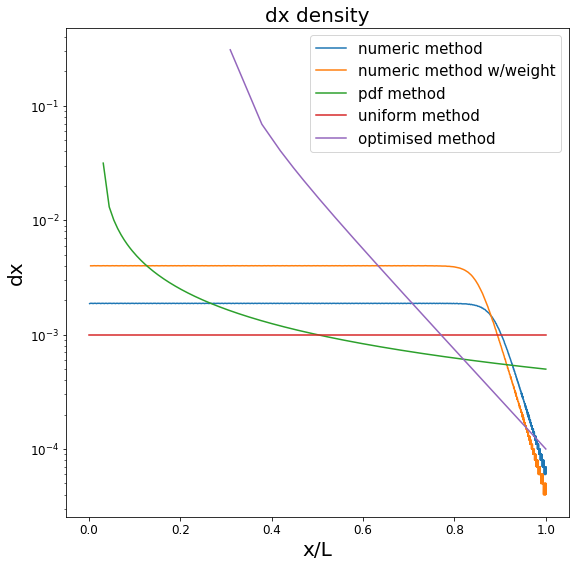

In [17]:
# plot the 
fig, ax = plt.subplots(figsize=[9, 9])
for i, xs in enumerate(zip([xs_nuni_1, xs_nuni_2, xs_nuni_3, xs_uni, xs_opt])):
    x = xs[0][-1]
    dx = np.diff(x)
    x_tmp = x / max(x)
    ax.semilogy(x_tmp[1:], dx, label=labels[i])
ax.legend()
ax.set(title='dx density', xlabel='x/L', ylabel='dx')

As we can see above the two numerical methods have a sharp turn around $x/L = 0.8$ as well as some shaky behaviour near $x/L=1$. 
The main issue here is the sharp turn. 
Normally when we derive truncation errors we rely on the canceling of a dx in the leading term. If we were to go through a derivation of the truncation error for a non-uniform dx (not actually done here due to time constraints), then we would likely see that the error is smallest when the dx is roughly constant either side of the point (so they can roughly cancel). Hence we need a slowly changing dx to minimse this effect, and the sharp turn has a big impact.

This is just one possible explanation, but it is the most logical to me. The jagged ends could also be a significant factor too. Either way we can see that numerically formulated grids struggle.

## Iterative approach
Now we are trying to generate a non-uniform grid from a solution a steepness tolerance, which I have interpreted to mean difference in y value as the actual dy/dx might remain larger than the tolerance regardless of how many times you subdivide the interval as dx will be shrinking too. After the previous analysis I do not expect wonderful things.

In [18]:
def update_grid(old_grid, sol, tol):
    dys = np.diff(sol)
    indexs = np.where(dys > tol)[0]  # regions to subdivide
    
    edges = old_grid.tolist()
    for i in indexs:
        new_edge = (old_grid[i] + old_grid[i+1]) / 2
        edges.append(new_edge)
    return np.array(sorted(edges)), len(indexs)

# test this function
# old = np.linspace(0, 1, 10)
# test_vals = [0, 0, 0, 0, 0, .1, .7, 10, 11, 11.1]  # should divide 3
# new = update_grid(old, test_vals, 0.5)
# print(list(zip(old, new)))
# print(len(new))

In [20]:
# params
kappa, U, L = 1/30, 1., 1.
BV = [0., 1.]
lims = [0., L]
Pe = U * L / kappa
tol = 0.01

# setup
initial_grid = np.linspace(0, L, 50)
x_store = [initial_grid]
solution_store = [stationary_nonuniform(initial_grid, kappa, U, L, BV, lims)]

# start loop
errors, N_list = [], []
divides = 2  # start loop
while divides > 1:
    # solve
    new_grid, divides = update_grid(x_store[-1], solution_store[-1], tol)
    solution_store.append(stationary_nonuniform(new_grid, kappa, U, L, BV, lims))
    x_store.append(new_grid)
    
    # find the error
    exact = stationary_exact(Pe, x_store[-1])
    diff_sq = (solution_store[-1] - exact)**2
    err = np.sqrt(diff_sq.sum()/len(exact))
    print(err, len(exact))
    errors.append(err)
    N_list.append(len(exact))
print('\ndone')

print('for N=%i, err = %f' % (len(exact), errors[-1]))

Solving steady state with non-uniform dx =  0.02040816326530612
Solving steady state with non-uniform dx =  0.017857142857142856
0.0010984680915899607 57
Solving steady state with non-uniform dx =  0.014925373134328358
0.0006366439850914984 68
Solving steady state with non-uniform dx =  0.011764705882352941
0.0005568090191237832 86
Solving steady state with non-uniform dx =  0.008928571428571428
0.0005534848087681596 113
Solving steady state with non-uniform dx =  0.006802721088435373
0.0005381675370297095 148
Solving steady state with non-uniform dx =  0.0055248618784530384
0.0005028399595745185 182
Solving steady state with non-uniform dx =  0.0055248618784530384
0.0005028399595745185 182

done
for N=182, err = 0.000503


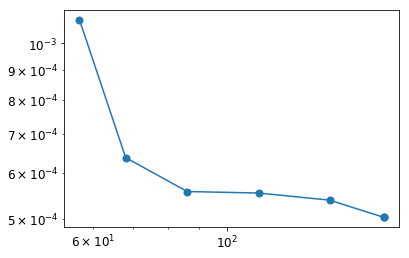

In [21]:
plt.loglog(N_list, errors, '-o')

We can see as the solution iterates we increase the number of points and decrease the error, which is what we want. However the rate of this convergence compared to the previous methods is questionable. To better see this lets try converging over a range of different tolerances.

In [22]:
# tolerance convergence
# params
kappa, U, L = 1/30, 1., 1.
BV = [0., 1.]
lims = [0., L]
Pe = U * L / kappa
tols = np.array([1e-1/1.5**n for n in range(12)])

# setup
initial_grid = np.linspace(0, L, 50)
x_store = [initial_grid]
solution_store = [stationary_nonuniform(initial_grid, kappa, U, L, BV, lims)]

# start loop
errors, N_list = [], []
for tol in tols:
    divides = 2  # start loop
    while divides > 1:
        # solve
        new_grid, divides = update_grid(x_store[-1], solution_store[-1], tol)
        solution_store.append(stationary_nonuniform(new_grid, kappa, U, L, BV, lims))
        x_store.append(new_grid)

    # find the error
    exact = stationary_exact(Pe, x_store[-1])
    diff_sq = (solution_store[-1] - exact)**2
    err = np.sqrt(diff_sq.sum()/len(exact))
    errors.append(err)
    N_list.append(len(exact))

print('\ndone')

Solving steady state with non-uniform dx =  0.02040816326530612
Solving steady state with non-uniform dx =  0.019230769230769232
Solving steady state with non-uniform dx =  0.017857142857142856
Solving steady state with non-uniform dx =  0.01694915254237288
Solving steady state with non-uniform dx =  0.01694915254237288
Solving steady state with non-uniform dx =  0.015384615384615385
Solving steady state with non-uniform dx =  0.015384615384615385
Solving steady state with non-uniform dx =  0.013513513513513513
Solving steady state with non-uniform dx =  0.013513513513513513
Solving steady state with non-uniform dx =  0.010869565217391304
Solving steady state with non-uniform dx =  0.010869565217391304
Solving steady state with non-uniform dx =  0.008928571428571428
Solving steady state with non-uniform dx =  0.008928571428571428
Solving steady state with non-uniform dx =  0.006578947368421052
Solving steady state with non-uniform dx =  0.006578947368421052
Solving steady state with no

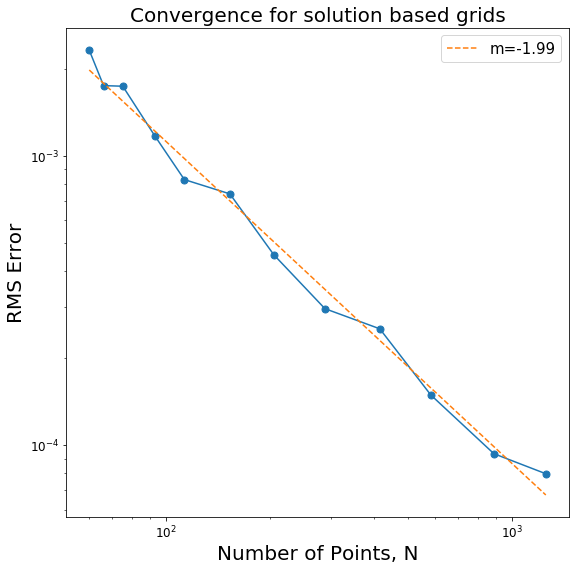

In [23]:
# plot solutions
fig, ax = plt.subplots(figsize=[9, 9])
ax.loglog(N_list, errors, '-o')
ax.set(xlabel='Number of Points, N', ylabel='RMS Error', title='Convergence for solution based grids')
    
# fit to linear regions to FTCS and BCTS
log_Ns = np.log10(N_list)
params = np.polyfit(log_Ns[:], np.log10(errors), 1)

# plot linear fits
ax.plot(N_list, de_log(N_list, *params), '--', label='m=%.2f' % uni_params[0])
ax.legend()

Considering the number of points in the final grid that satisfies the given tolerance we can obtain a convergence plot which is 2nd order just like the previous methods. However the error at a given N is far worse compared with the other methods. For N values of around $5\times10^3$ we are getting error orders of downwards of $10^{-4}$, where as the optimal or pdf methods has that level of error for just $N=2\times10^2$. Even the uniform grid does better. Once you also consider that each N requires several runs of different N values we understand this method is not by any means competitive. This increased error despite more computation is likely due to the halving method causing frequent sharp changes in consecutive dx values as previously discussed.

In [24]:
# well done for making it though :)